# NGC 309: Spatial matching of the post-processed imaging data cube with the IFS data (Part2: spec-photo rescaling)

In [1]:
import numpy as np
import math
import sys
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME+'/src')

## Call function rescale_specphoto_map for rescaling pixel-wise spectroscopic SED to mach the overall normalization of the photometric SED

In [ ]:
from piXedfit_spectrophotometric import rescale_specphoto_map

### Running the calculation
It is recommended to run this calculation on a cluster that has multiple cores 

In [ ]:
## set of photometric filters
filters = ['galex_fuv', 'galex_nuv', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z',
            '2mass_j', '2mass_h', '2mass_k', 'wise_w1', 'wise_w2']

## input data cube:
specphoto_fits = 'specphoto_crop_fluxmap_califa_NGC309.fits'
spec_sigma = 2.6
## name of the FITS file containing the model SEDs templates: 
name_saved_randmod = 'savedmodels_Cal20_dpl_800k.fits'
## Number of processors to be used:
nproc = 80
## name of output FITS file:
out_fits_name = 'match_%s' % specphoto_fits
bfit_spec = None
rescale_specphoto_map(specphoto_fits=specphoto_fits,spec_sigma=spec_sigma,filters=filters,name_saved_randmod=name_saved_randmod,
                                                        nproc=nproc,bfit_spec=bfit_spec,out_fits_name=out_fits_name)

### Check the FITS file containing the post-processed spectrophotometric data product

In [2]:
cube = fits.open("match_specphoto_crop_fluxmap_califa_NGC309.fits.gz")
cube.info()
header = cube[0].header
print (header)

Filename: match_specphoto_crop_fluxmap_califa_NGC309.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  2  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  3  PHOTO_FLUX    1 ImageHDU         9   (131, 131, 12)   float64   
  4  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  5  WAVE          1 ImageHDU         7   (1899,)   float64   
  6  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1899)   float64   
  7  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1899)   float64   
  8  MOD_WAVE      1 ImageHDU         7   (4942,)   float64   
  9  MOD_FLUX      1 ImageHDU         9   (131, 131, 4942)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of a

In [3]:
photo_region = cube['PHOTO_REGION'].data
spec_region = cube['SPEC_REGION'].data
wave = cube['wave'].data
photo_flux = cube['PHOTO_FLUX'].data
photo_flux_err = cube['PHOTO_FLUXERR'].data
spec_flux = cube['SPEC_FLUX'].data
spec_flux_err = cube['SPEC_FLUXERR'].data
mod_wave = cube['MOD_WAVE'].data
mod_flux = cube['MOD_FLUX'].data

### Get the pixel-wise spectrophototmetric SED

In [4]:
## get dimension of the galaxy:
dim_y = photo_region.shape[0]
dim_x = photo_region.shape[1]

### get photometric and spectroscopic SEDs of pixels:
#transpose photometric SEDs from (band,y,x) => (y,x,band):
pix_photo_SED = np.transpose(photo_flux, axes=(1, 2, 0))*1.0e-17     ## 1e-17erg/s/cm^2/A is unit of flux in the fits file
pix_photo_SED_err = np.transpose(photo_flux_err, axes=(1, 2, 0))*1.0e-17

#transpose spectroscopic SEDs and its masking flag from (wavelength,y,x) => (y,x,wavelength):
pix_spec_SED = np.transpose(spec_flux, axes=(1, 2, 0))*1.0e-17
pix_spec_SED_err = np.transpose(spec_flux_err, axes=(1, 2, 0))*1.0e-17

pix_mod_spec_SED = np.transpose(mod_flux, axes=(1,2,0))*1.0e-17


### Get the set of photometric filters and their central wavelengths

In [5]:
### get filters:
nbands = int(header['nfilters'])
filters = []
for bb in range(0,nbands):
    str_temp = "fil%d" % bb
    filters.append(header[str_temp])
    
print (filters)

from filtering import cwave_filters
eff_wave = cwave_filters(filters)
print (eff_wave)

['galex_fuv', 'galex_nuv', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z', '2mass_j', '2mass_h', '2mass_k', 'wise_w1', 'wise_w2']
[ 1516.  2267.  3351.  4686.  6166.  7480.  8932. 12358. 16458. 21603.
 33526. 46028.]


### Plot the SEDs of 36 pixels within central 6x6  
Blue squares: photometric SED;
red: spectroscopic SED;
black: best-fit model SED that was used for rescaling the observed spectrum (from the IFS data)

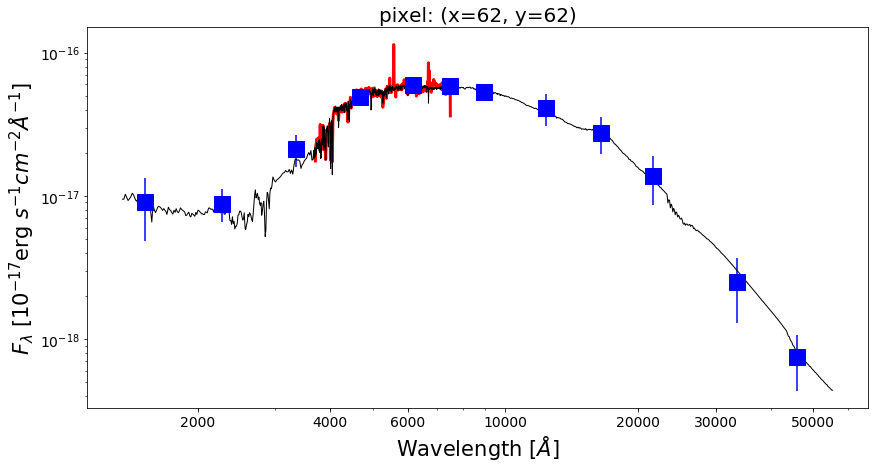

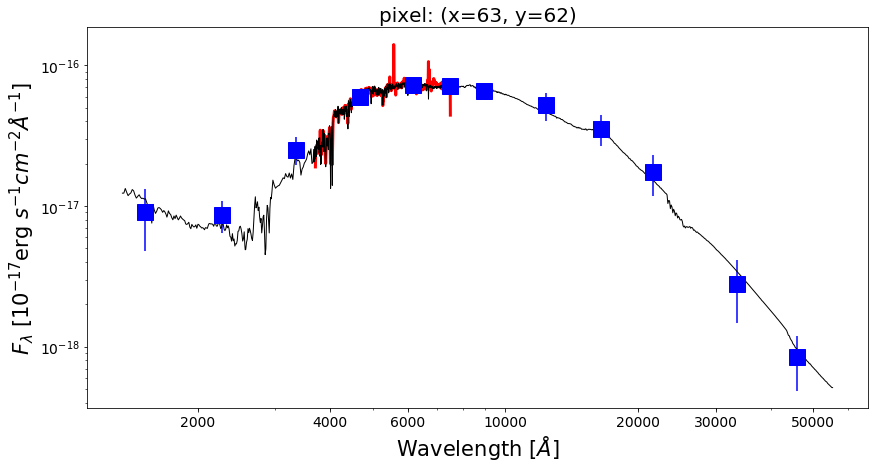

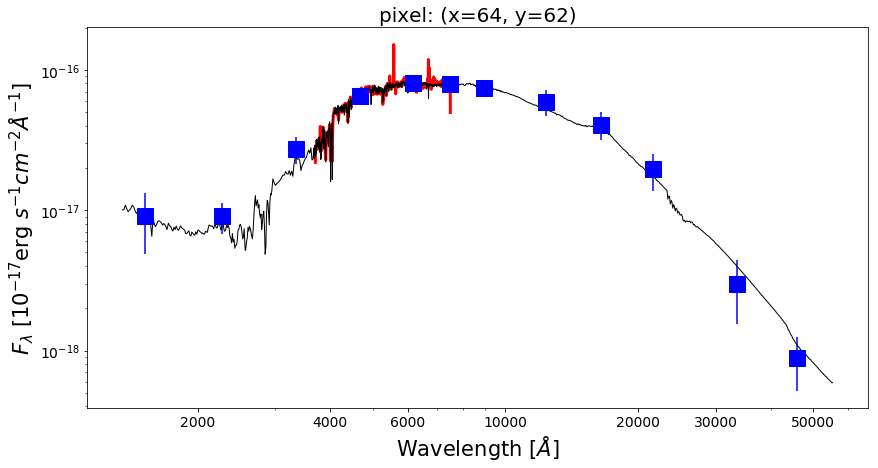

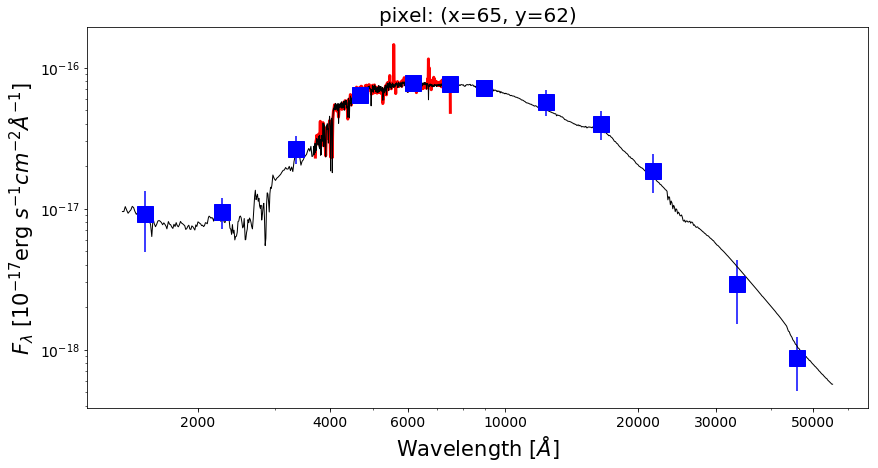

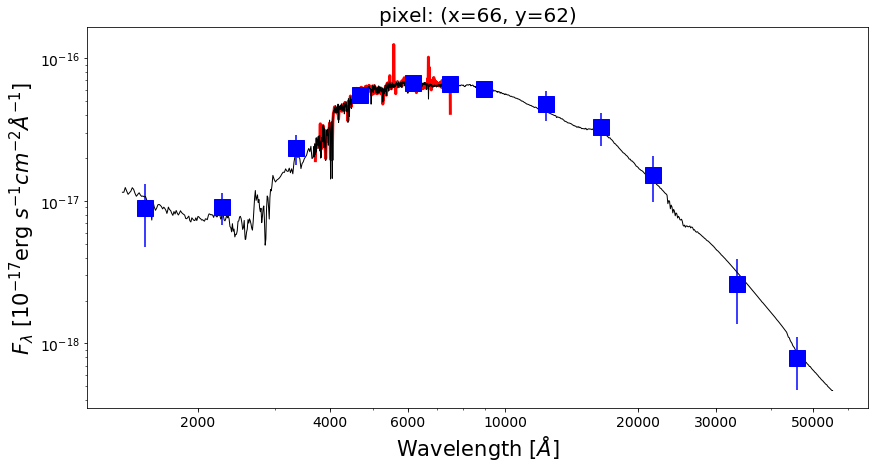

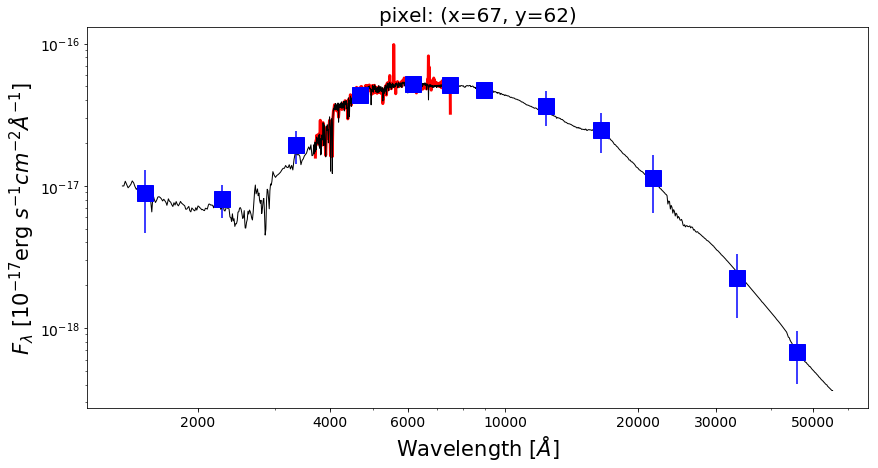

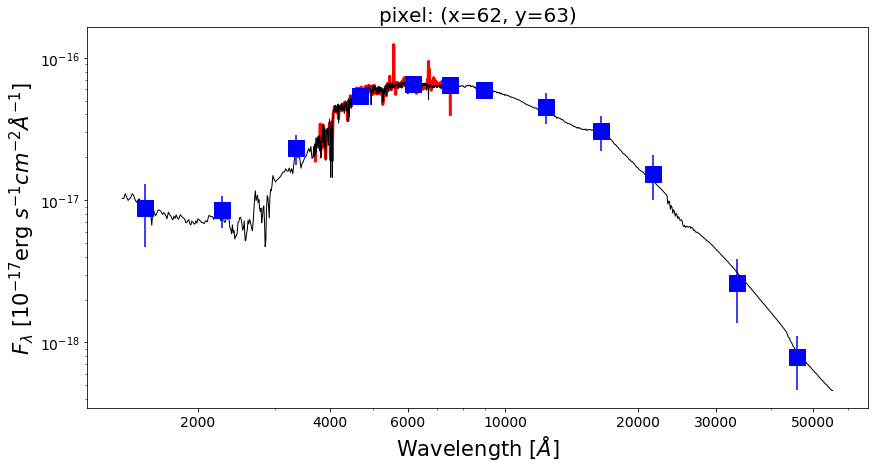

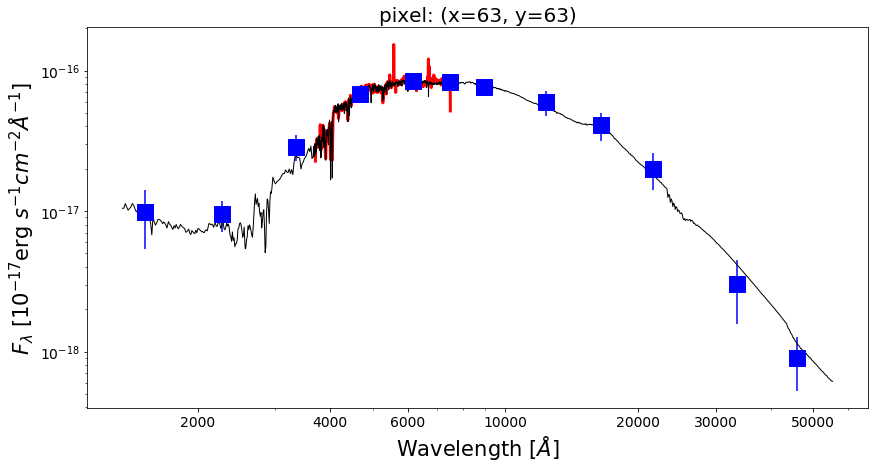

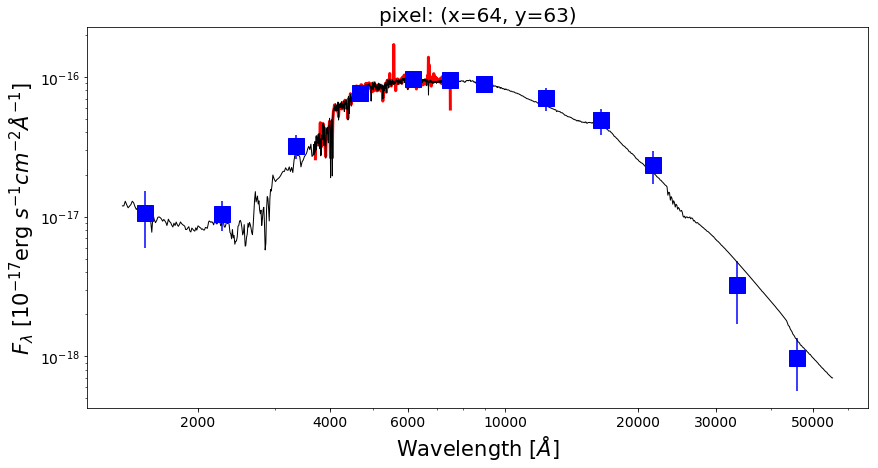

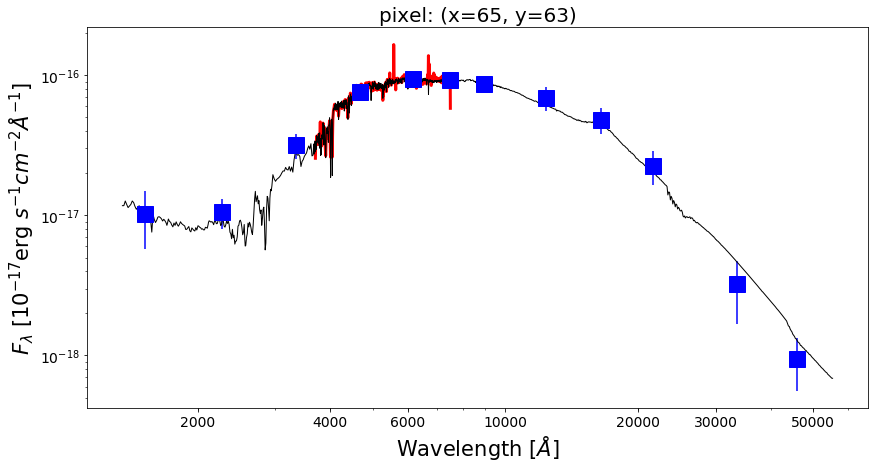

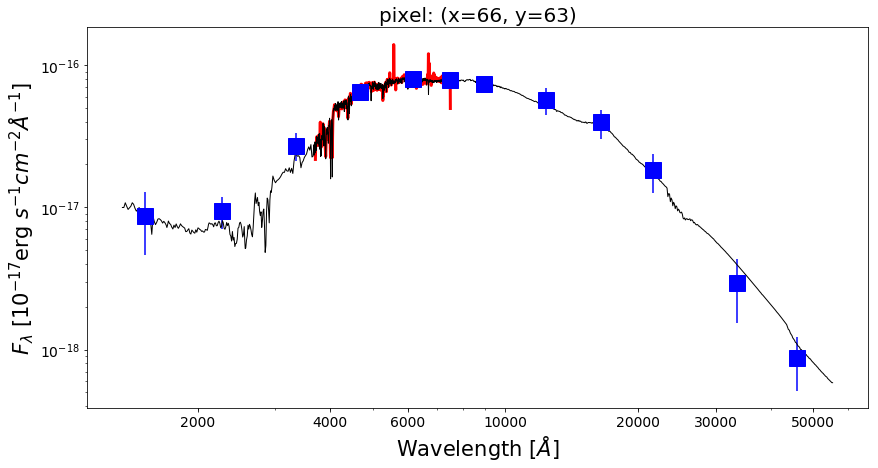

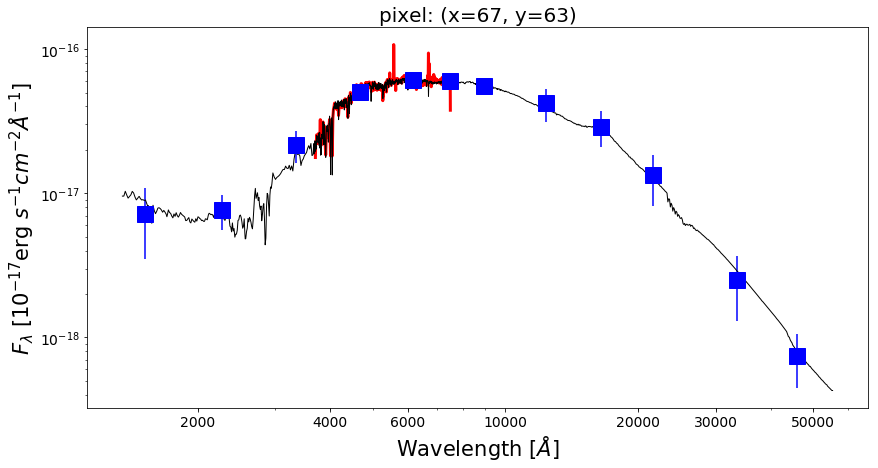

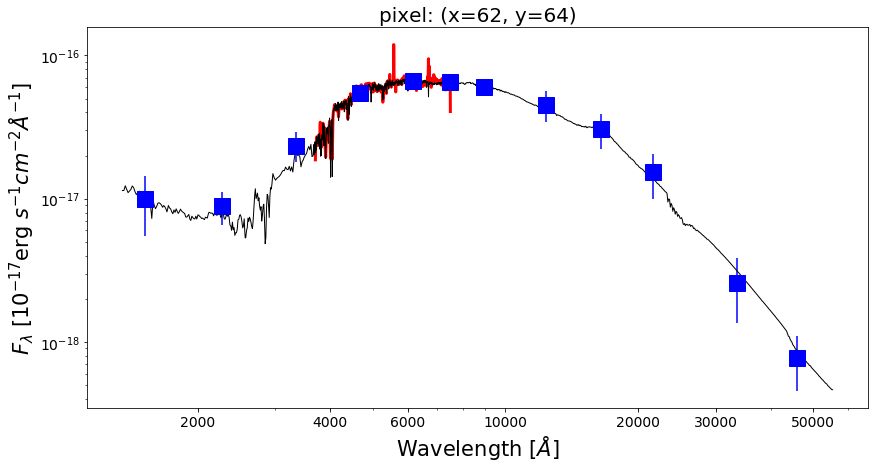

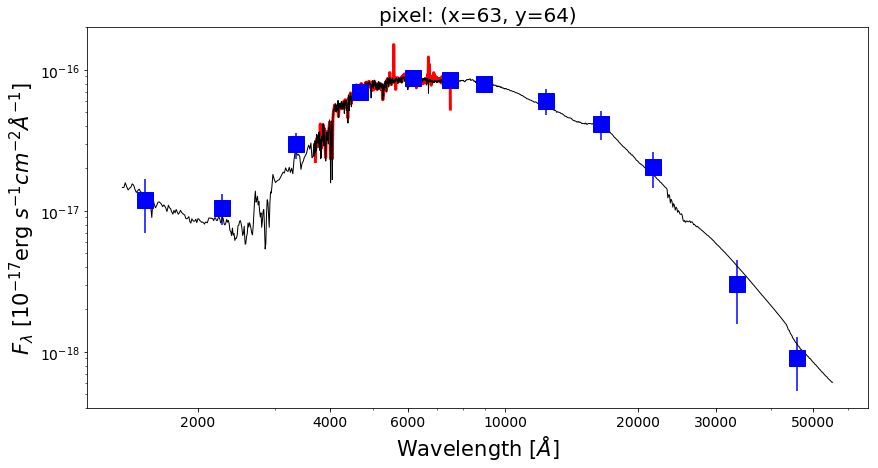

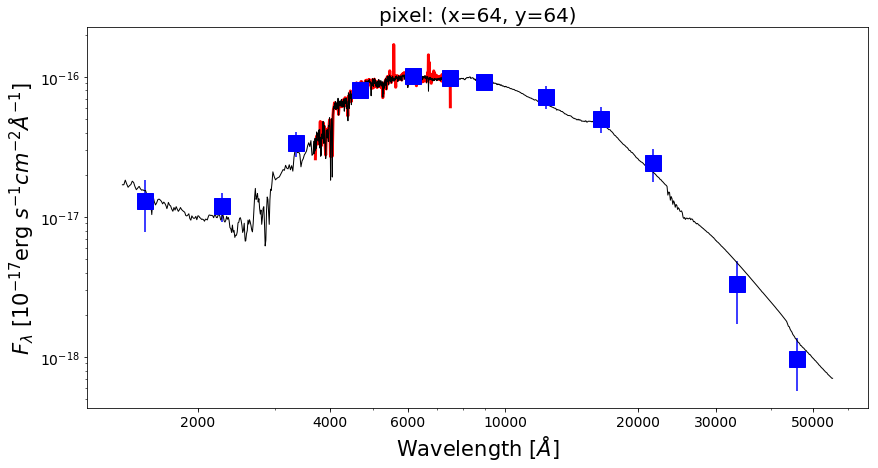

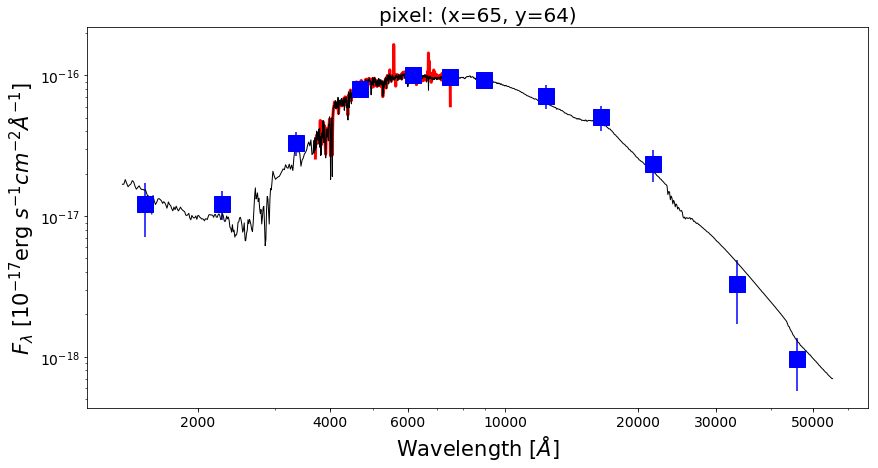

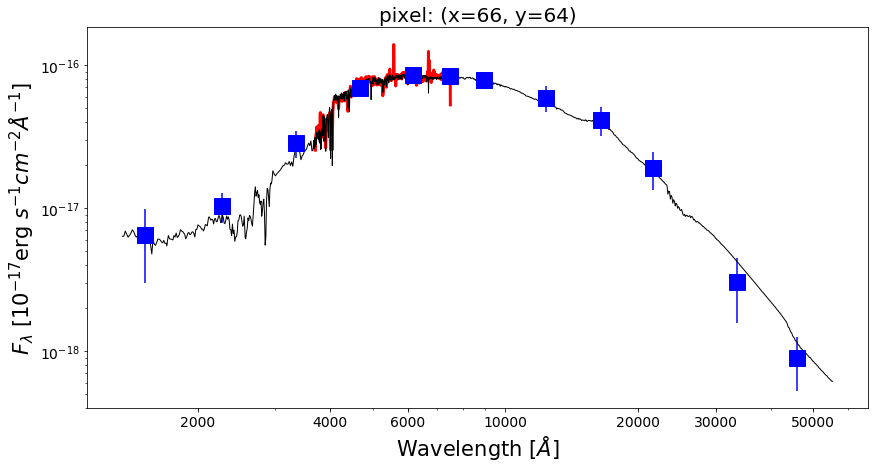

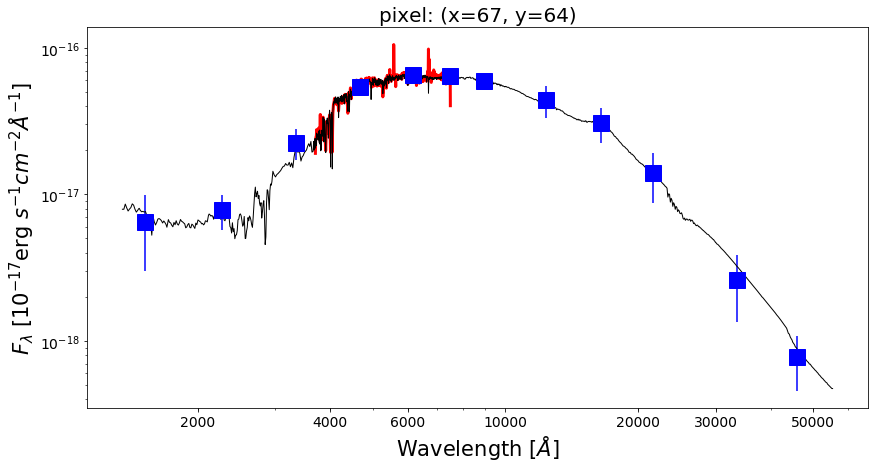

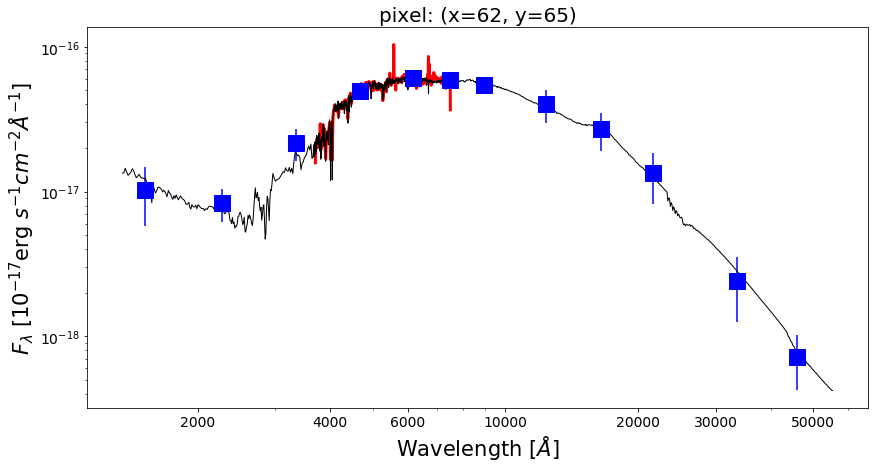

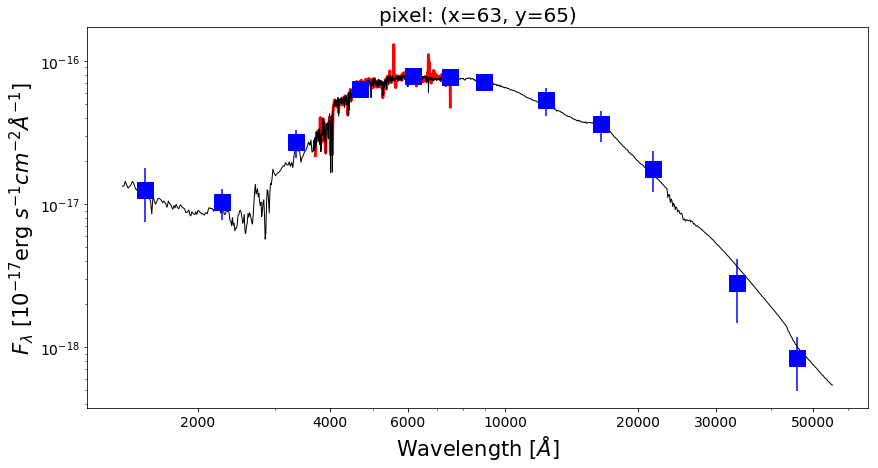

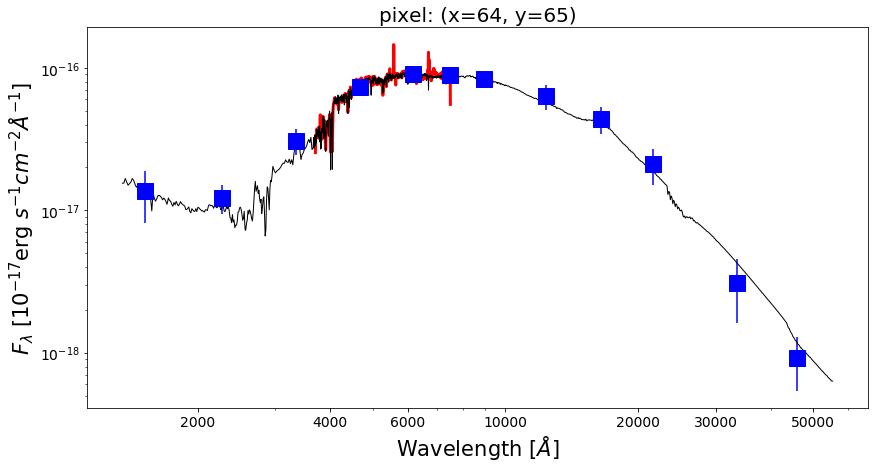

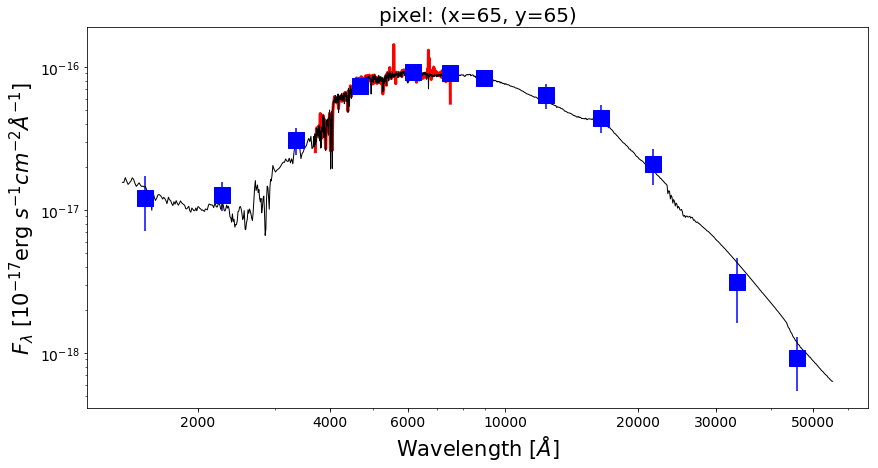

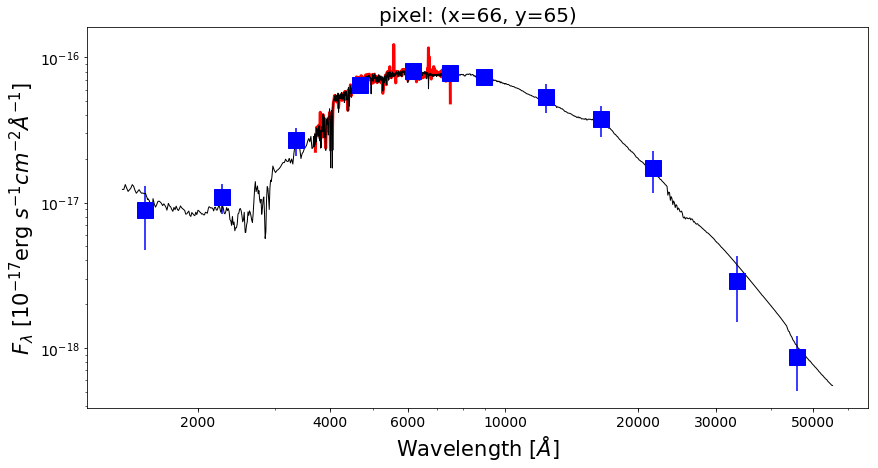

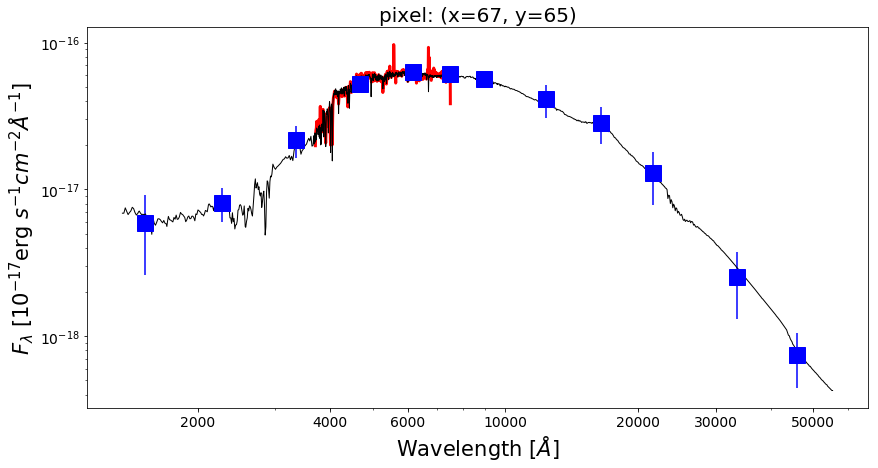

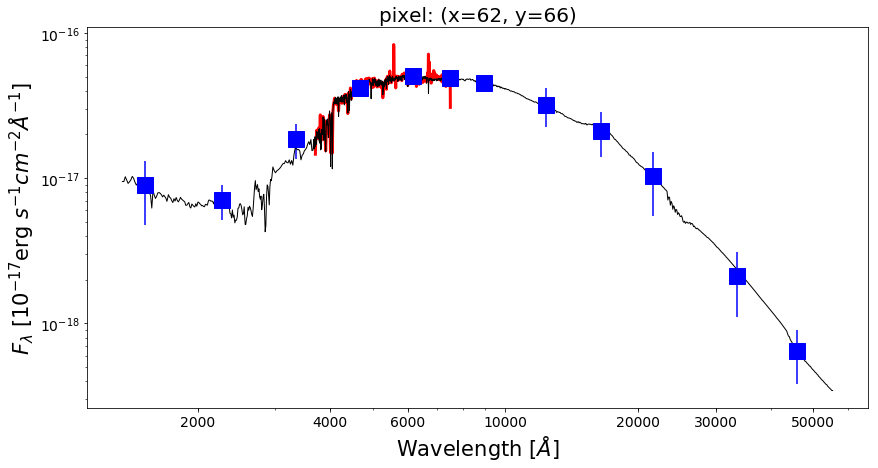

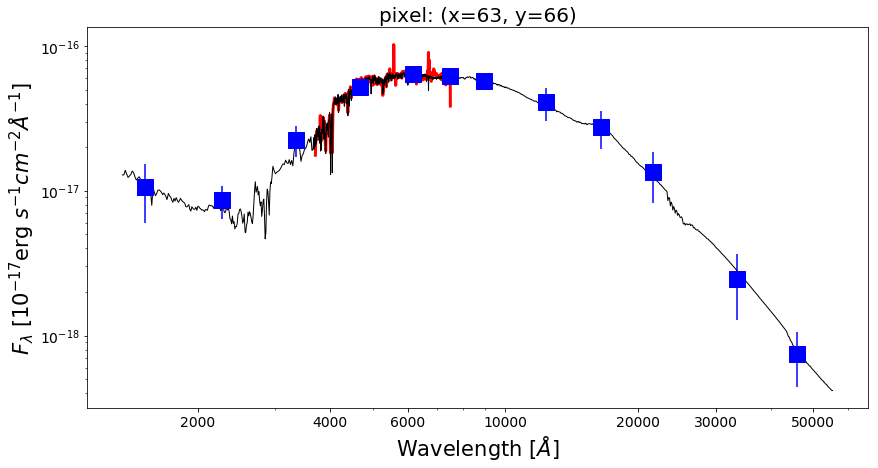

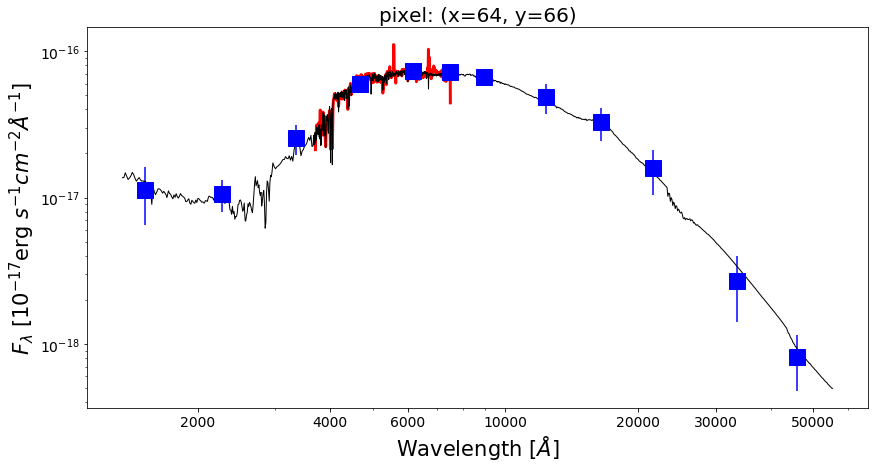

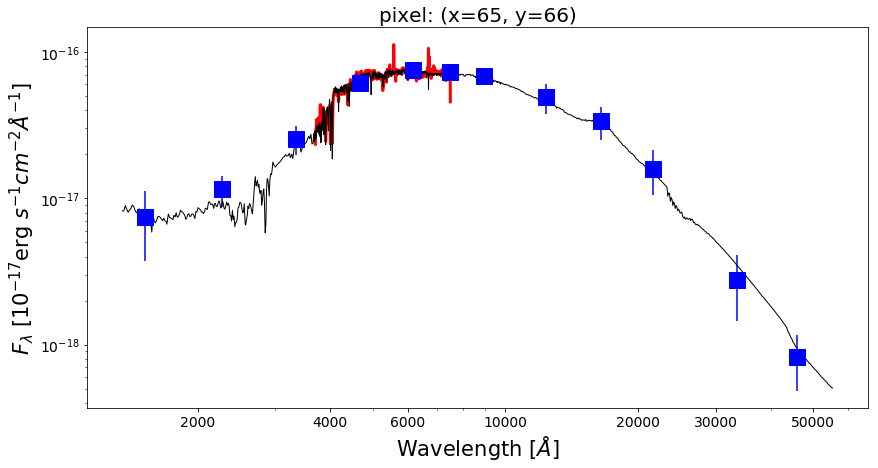

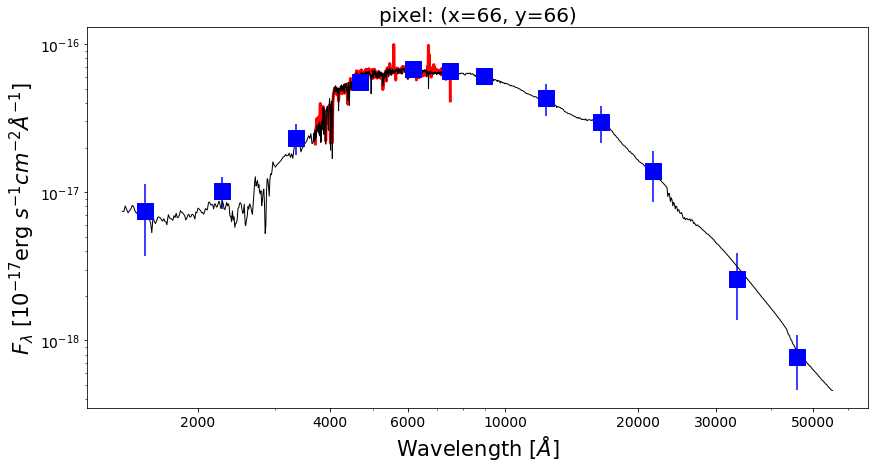

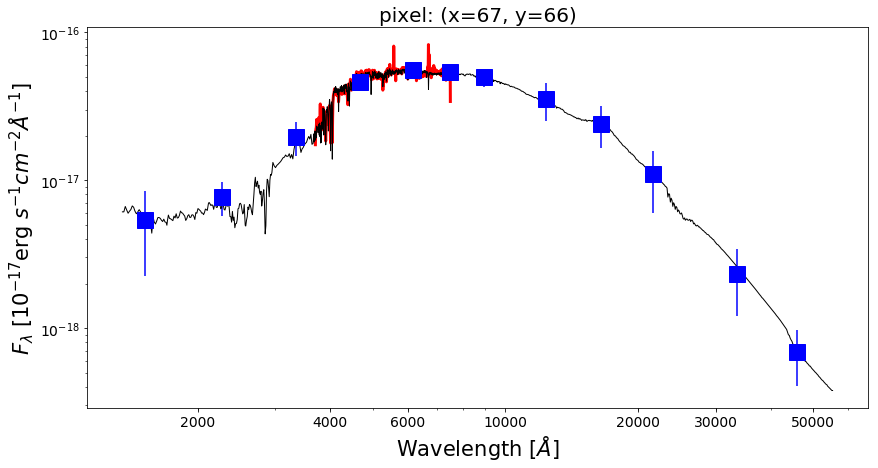

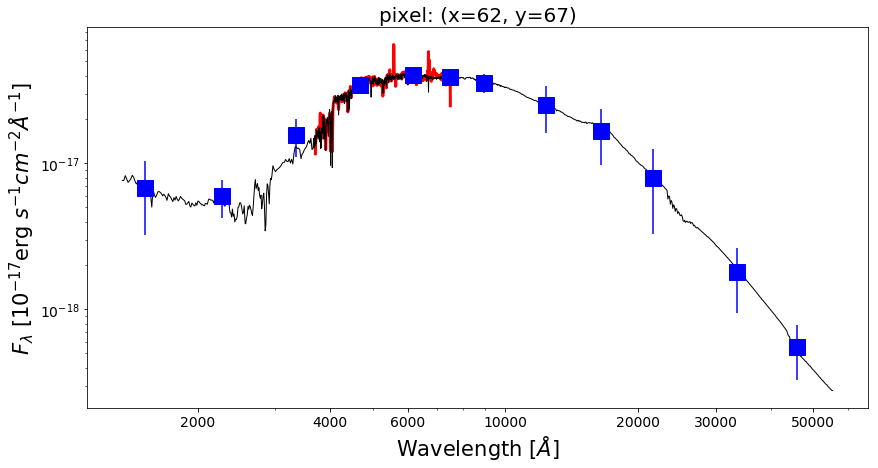

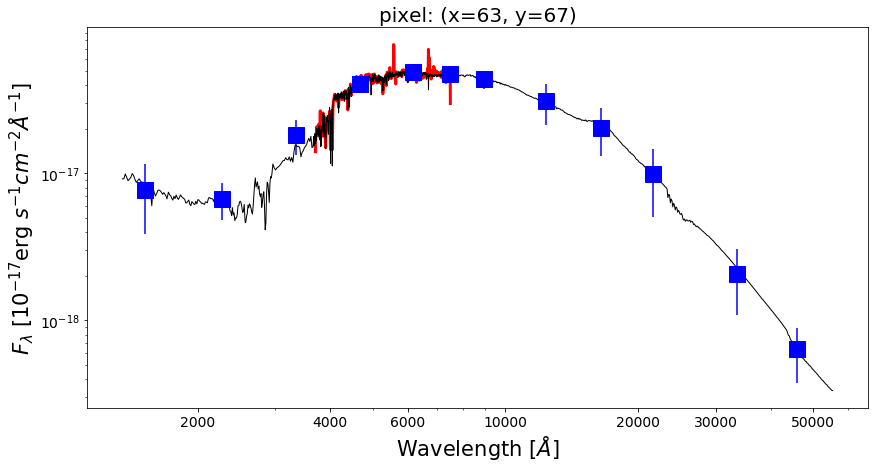

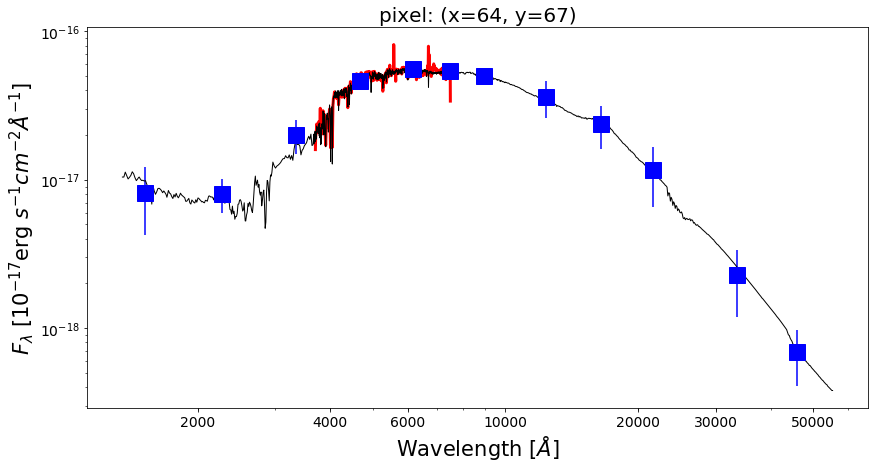

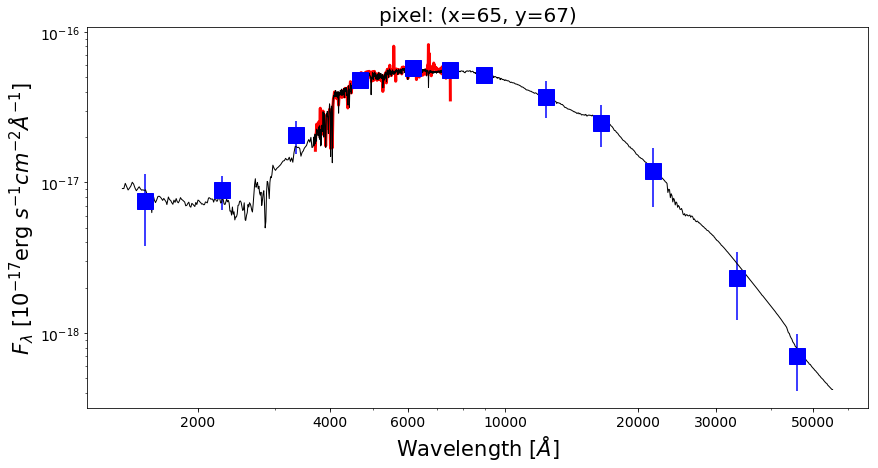

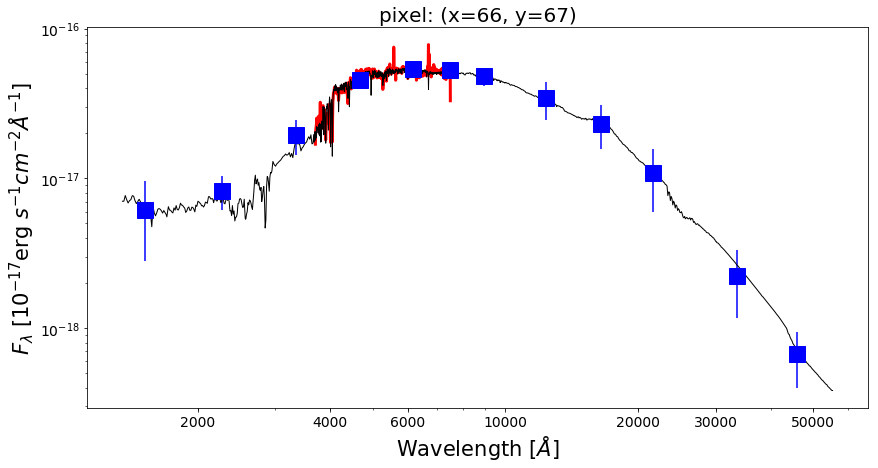

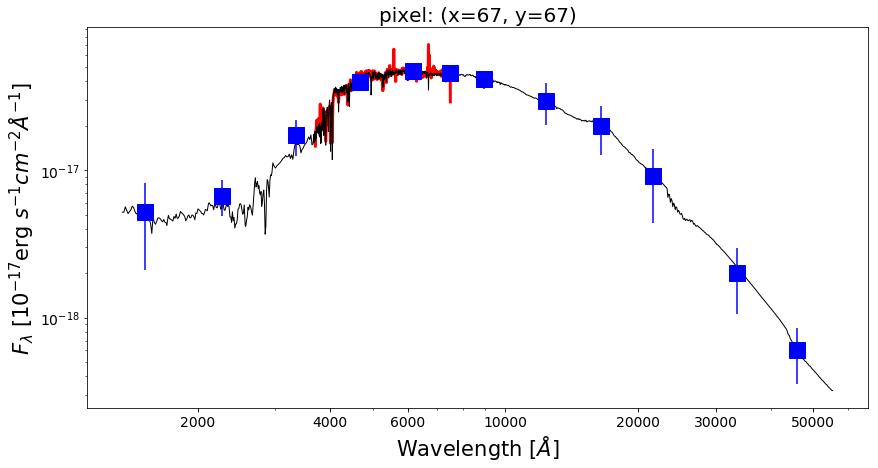

In [7]:
count_pix = 0
for yy in range(62,68):
    for xx in range(62,68): 
        if spec_region[int(yy)][int(xx)]==1:
            count_pix = count_pix + 1
            
            fig1 = plt.figure(figsize=(14,7))
            f1 = plt.subplot()   
            plt.title("pixel: (x=%d, y=%d)" % (xx,yy), fontsize=20)
            f1.set_yscale('log')
            f1.set_xscale('log')
            plt.setp(f1.get_yticklabels(), fontsize=14)
            plt.setp(f1.get_xticklabels(), fontsize=14)
            plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
            plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
            xticks = [2000,4000,6000,10000,20000,30000,50000]
            plt.xticks(xticks)
            #plt.xlim(3000,10000)
            #plt.ylim(1.0e-19,8e-16)
            for axis in [f1.xaxis]:
                axis.set_major_formatter(ScalarFormatter())
            
            plt.plot(wave, pix_spec_SED[int(yy)][int(xx)], lw=3.0, color='red')
            plt.errorbar(eff_wave, pix_photo_SED[int(yy)][int(xx)], 
                         yerr=pix_photo_SED_err[int(yy)][int(xx)], markersize=16,
                        color='blue', fmt='s')
            
            plt.plot(mod_wave, pix_mod_spec_SED[int(yy)][int(xx)], lw=1.0, color='black')

### Plot spectrophotometric SEDs of some pixels

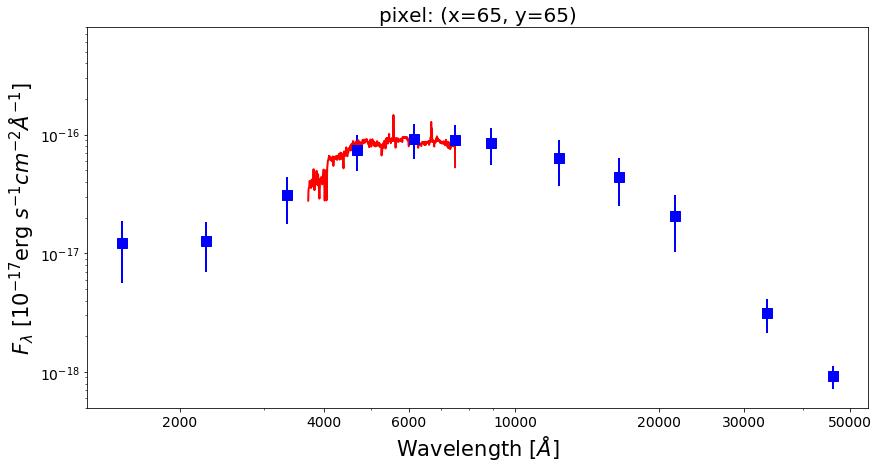

In [10]:
### get spectrum:
x = 65
y = 65

photo_SED = pix_photo_SED[y][x]
photo_SED_err = pix_photo_SED_err[y][x]
spec_SED = pix_spec_SED[y][x]
spec_SED_err = pix_spec_SED_err[y][x]


### plotting
fig1 = plt.figure(figsize=(14,7))
f1 = plt.subplot()   
plt.title("pixel: (x=%d, y=%d)" % (x,y), fontsize=20)
f1.set_yscale('log')
f1.set_xscale('log')
plt.setp(f1.get_yticklabels(), fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=14)
plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
xticks = [2000,4000,6000,10000,20000,30000,50000]
plt.xticks(xticks)
#plt.xlim(3000,10000)
plt.ylim(5.0e-19,8e-16)
for axis in [f1.xaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.plot(wave, spec_SED, lw=2.0, color='red')
plt.errorbar(eff_wave, photo_SED, yerr=photo_SED_err, markersize=10,
                        color='blue', fmt='s', lw=2)

name_out = "sed_x%d_y%d.png" % (x,y)
plt.savefig(name_out)

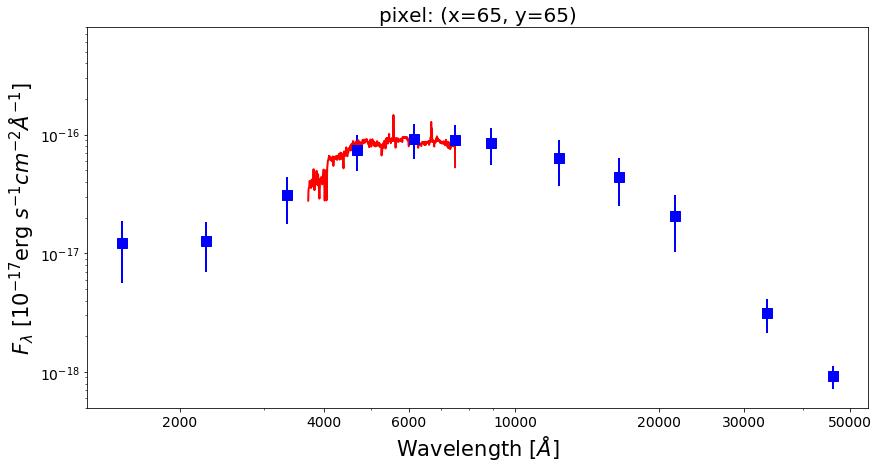

In [11]:
### get spectrum:
x = 65
y = 65

photo_SED = pix_photo_SED[y][x]
photo_SED_err = pix_photo_SED_err[y][x]
spec_SED = pix_spec_SED[y][x]
spec_SED_err = pix_spec_SED_err[y][x]


### plotting
fig1 = plt.figure(figsize=(14,7))
f1 = plt.subplot()   
plt.title("pixel: (x=%d, y=%d)" % (x,y), fontsize=20)
f1.set_yscale('log')
f1.set_xscale('log')
plt.setp(f1.get_yticklabels(), fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=14)
plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
xticks = [2000,4000,6000,10000,20000,30000,50000]
plt.xticks(xticks)
#plt.xlim(3000,10000)
plt.ylim(5.0e-19,8e-16)
for axis in [f1.xaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.plot(wave, spec_SED, lw=2.0, color='red')
plt.errorbar(eff_wave, photo_SED, yerr=photo_SED_err, markersize=10,
                        color='blue', fmt='s', lw=2)

name_out = "sed_x%d_y%d.png" % (x,y)
plt.savefig(name_out)